In [129]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
import cv2
import os
import glob
import random
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


In [130]:
# From https://github.com/deepmind/3d-shapes/blob/master/3dshapes_loading_example.ipynb
# load dataset
dataset = h5py.File('3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}


<KeysViewHDF5 ['images', 'labels']>


In [150]:
print(labels[92])

[  0.           0.           0.           0.82142857   2.
 -21.42857143]


In [131]:
# From https://github.com/deepmind/3d-shapes/blob/master/3dshapes_loading_example.ipynb

def get_index(factors):
    """ Converts factors to indices in range(num_data)
    Args:
    factors: np array shape [6,batch_size].
                factors[i]=factors[i,:] takes integer values in 
                range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[i]]).

    Returns:
    indices: np array shape [batch_size].
    """
    indices = 0
    base = 1
    for factor, name in reversed(list(enumerate(_FACTORS_IN_ORDER))):
        indices += factors[factor] * base
        base *= _NUM_VALUES_PER_FACTOR[name]
    return indices

def get_images_by_factor(factors):
    imgs = []
    factors = np.zeros([len(_FACTORS_IN_ORDER), 480],
                    dtype=np.int32)
    

def sample_batch(batch_size, fixed_factor, fixed_factor_value):
    """ Samples a batch of images with fixed_factor=fixed_factor_value, but with
    the other factors varying randomly.
  Args:
    batch_size: number of images to sample.
    fixed_factor: index of factor that is fixed in range(6).
    fixed_factor_value: integer value of factor that is fixed 
      in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

  Returns:
    batch: images shape [batch_size,64,64,3]
  """
    factors = np.zeros([len(_FACTORS_IN_ORDER), batch_size],
                        dtype=np.int32)
    for factor, name in enumerate(_FACTORS_IN_ORDER):
        num_choices = _NUM_VALUES_PER_FACTOR[name]
        factors[factor] = np.random.choice(num_choices, batch_size)
    factors[fixed_factor] = fixed_factor_value
    indices = get_index(factors)
    ims = []
    for ind in indices:
        im = images[ind]
        im = np.asarray(im)
        ims.append(im)
    ims = np.stack(ims, axis=0)
    ims = ims / 255. # normalise values to range [0,1]
    ims = ims.astype(np.float32)
    return ims.reshape([batch_size, 64, 64, 3])


def get_all_shapes():
    """ Samples a batch of images with fixed_factor=fixed_factor_value, but with
    the other factors varying randomly.
  Args:
    batch_size: number of images to sample.
    fixed_factor: index of factor that is fixed in range(6).
    fixed_factor_value: integer value of factor that is fixed 
      in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

  Returns:
    batch: images shape [batch_size,64,64,3]
  """
    factors = np.zeros([len(_FACTORS_IN_ORDER), 480],
                      dtype=np.int32)

    for scale in range(8):
            for shape in range(4):
                for orientation in range(15):
                        factors[_FACTORS_IN_ORDER.index('scale')][scale + shape*8 + orientation *4*8] = scale
                        factors[_FACTORS_IN_ORDER.index('shape')][scale + shape*8 + orientation *4*8] = shape
                        factors[_FACTORS_IN_ORDER.index('orientation')][scale + shape*8 + orientation *4*8] = orientation
    factors[_FACTORS_IN_ORDER.index('floor_hue')]= 5
    factors[_FACTORS_IN_ORDER.index('wall_hue')] = 5
    factors[_FACTORS_IN_ORDER.index('object_hue')] = 1

    indices = get_index(factors)
    ims = []
    lbls = []
    for ind in indices:
        im = images[ind]
        im = np.asarray(im)
        ims.append(im)
        lbls.append(labels[ind])
    ims = np.stack(ims, axis=0)
    ims = ims / 255. # normalise values to range [0,1]
    ims = ims.astype(np.float32)
    return ims.reshape([480, 64, 64, 3]), lbls




In [132]:
def show_images_grid(imgs_, num_images=25, index = 0):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i + index], cmap='Greys_r', interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')





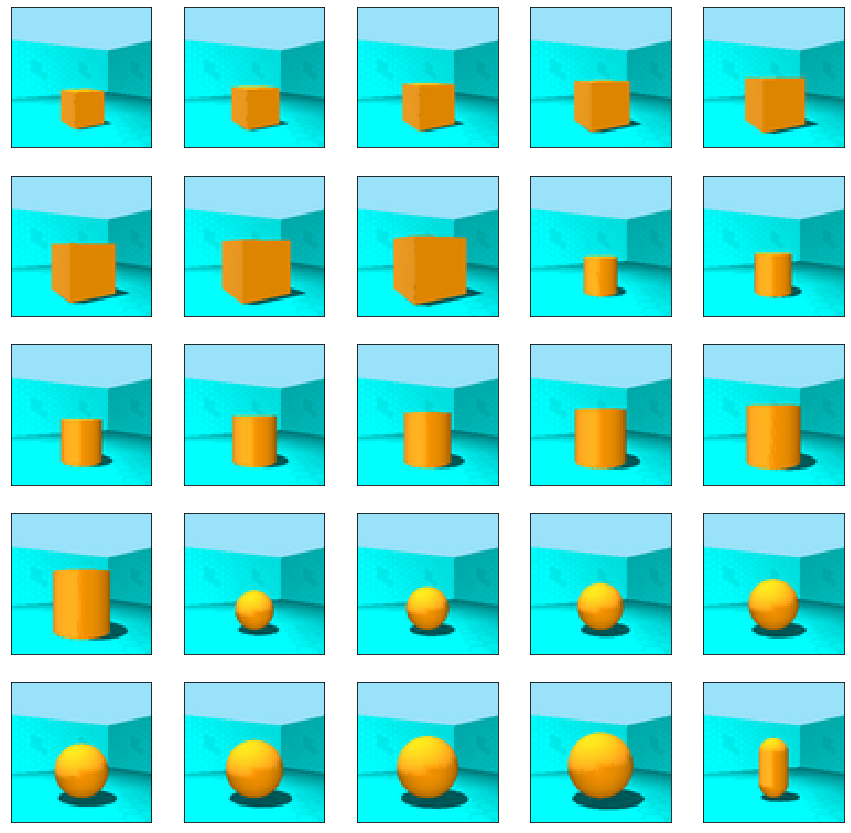

In [133]:
batch_size = 25
fixed_factor_str = 'floor_hue' #@param ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
fixed_factor_value = 5  # first value of floor hue - red
fixed_factor = _FACTORS_IN_ORDER.index(fixed_factor_str)  # floor hue
img_list_raw, lbl_batch = get_all_shapes()

show_images_grid(img_list_raw)


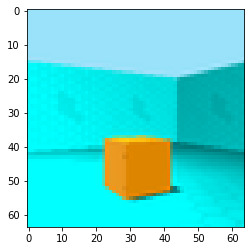

In [134]:
# show_images_grid(img_batch)

plt.imshow(img_list_raw[0])
plt.show()


In [139]:
# Convert images to black and white / countoured and save as H5 file

img_list_black_white = []
img_list_contour = []

# show_images_grid(img_batch)
for i in range(len(img_list_raw)):
    test_img = img_list_raw[i]
    test_img = test_img * 255. # normalise values to range [0,1]
    test_img = np.array(test_img, dtype = np.uint8) #convert back to int8
    test_img = cv2.cvtColor((test_img), cv2.COLOR_RGB2BGR) # Opencv uses BGR


    lower = np.array([10, 146, 46]) #lower threshold
    upper = np.array([71, 255, 255]) #upper threshold

    hsv = cv2.cvtColor(test_img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(test_img, test_img, mask=mask)

    # result[mask != 0] = [255,255,255]
    grayImage = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    canny_output = cv2.Canny(result, 100, 100 * 2)
    contours, hierarchy = cv2.findContours(canny_output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cim = np.zeros_like(result)
    cv2.drawContours(cim, contours, -1, (255,255,255), 1)
    grayImage_cont = cv2.cvtColor(cim, cv2.COLOR_BGR2GRAY)

    img_list_black_white.append(grayImage)
    img_list_contour.append(grayImage_cont)
    # cv2.imwrite('contour.png',grayImage_cont)
    # cv2.imwrite('blkwhite.png',grayImage)
    # print(grayImage_cont.shape)

    # plt.matshow(cim, cmap=plt.cm.gray)

    # break

hf = h5py.File('data_B+W.h5', 'w')
hf.create_dataset('images', data=img_list_black_white)
hf.create_dataset('labels', data=lbl_batch)
hf.close()

hf2 = h5py.File('data_contour.h5', 'w')
hf2.create_dataset('images', data=img_list_contour)
hf2.create_dataset('labels', data=lbl_batch)
hf2.close()


# test_img = test_img.astype(np.int8)

# print(test_img)
# cv2.imwrite('test.png',test_img)



In [175]:
# batch_size = 25
# fixed_factor_str = 'floor_hue' #@param ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
# fixed_factor_value = 1  # first value of floor hue - red
# fixed_factor = _FACTORS_IN_ORDER.index(fixed_factor_str)  # floor hue
# img_batch = sample_batch(batch_size, fixed_factor, fixed_factor_value)

# show_images_grid(img_batch)
print(len(img_list_raw))

NameError: name 'img_list_raw' is not defined

[  0.5          0.5          0.1          1.17857143   0.
 -21.42857143]


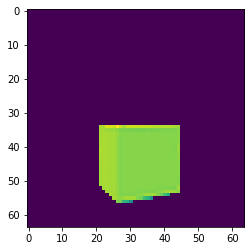

In [174]:
#***TEST loading dataset
hf = h5py.File('data_B+W.h5', 'r')
imgs = hf.get('images')
lbls = hf.get('labels')
num = 70
print(lbls[num])
# cv2.imwrite('test6.png',imgs[15])

plt.imshow(imgs[num])
plt.show()
